In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bayesflow as bf
from scipy.stats import norm
# import numda as nb

##Useful Functions

In [2]:
RNG = np.random.default_rng(2024)

In [3]:
def generate_gaussian_process(kernel_length, num_points):
    # Generate random numbers from a Gaussian distribution
    random_numbers = np.random.normal(0, 1, num_points)

    # Generate the kernel matrix
    kernel_matrix = np.exp(-(np.arange(num_points) - np.arange(num_points)[:, np.newaxis])**2 / (2 * kernel_length**2))
    kernel_matrix += 1e-6 * np.eye(num_points)
    # Multiply the kernel matrix by the random numbers
    gaussian_process = np.dot(np.linalg.cholesky(kernel_matrix), random_numbers)
    return gaussian_process


def normpdf(x, mean, sd,A):
    var = float(sd)**2
    num = A*np.exp(-(x-float(mean))**2/(2*var))
    return num


##simulator

In [4]:
def simulator_R(params, n_object=15, dt=1e-1):
    a, mean, sd, A, kernel_length, ndt = params[0], params[1], params[2], params[3],4, params[4]
    x = np.arange(360, dtype=np.float64)
    out = np.zeros((n_object, 2))
    prob_x = normpdf(x, mean, sd, A) * dt
    for i in range(n_object):
        num_iter = 0
        res = 0
        z = np.zeros(360, dtype=np.float64)
        while res == 0:
            # iterate over accumulators
            y = generate_gaussian_process(kernel_length, 360)
            # y = y / np.max(np.abs(y))
            y = y / 10
            z = z + prob_x + (y * np.sqrt(dt))
            respons = np.where(z >= a)
            if respons[0].size != 0:
                out[i, 0] = num_iter * dt + ndt
                out[i, 1] = float(np.random.choice(respons[0]))
                # out[i, 1] = float(np.random.choice(respons[0])*np.pi/180)
                res = 1
                break
            num_iter += 1

    return out

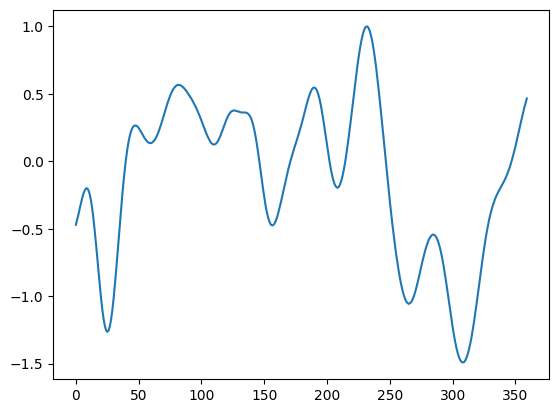

In [5]:
x = generate_gaussian_process(12, 360)
x = x/ np.max(x)
plt.plot(x)

CPU times: user 991 ms, sys: 5.86 s, total: 6.85 s
Wall time: 467 ms


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 4., 6., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([  0.        ,   7.32653061,  14.65306122,  21.97959184,
         29.30612245,  36.63265306,  43.95918367,  51.28571429,
         58.6122449 ,  65.93877551,  73.26530612,  80.59183673,
         87.91836735,  95.24489796, 102.57142857, 109.89795918,
        117.2244898 , 124.55102041, 131.87755102, 139.20408163,
        146.53061224, 153.85714286, 161.18367347, 168.51020408,
        175.83673469, 183.16326531, 190.48979592, 197.81632653,
        205.14285714, 212.46938776, 219.79591837, 227.12244898,
        234.44897959, 241.7755102 , 249.10204082, 256.42857143,
        263.75510204, 271.08163265, 278.40816327, 285.73469388,
        293.06122449, 300.3877551 , 307.71428571, 315.04081633,
        322.36734694, 329.69387755, 337.02040816, 344.34693878,
        35

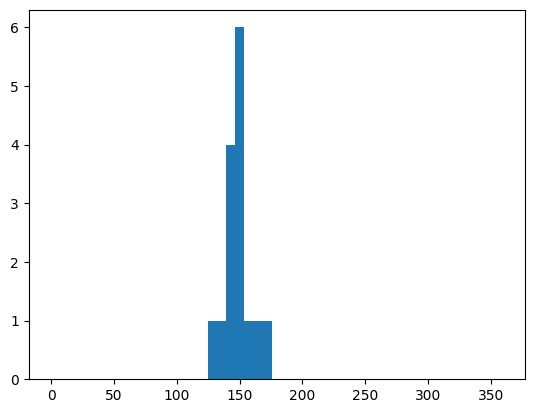

In [6]:
%%time
x = simulator_R(params=np.array([1,150,30,5,4,0],dtype=float))
plt.hist(x[:,1],bins = np.linspace(0,359))

In [7]:
simulator = bf.simulation.Simulator(simulator_fun=simulator_R)

##Prior

In [8]:
def Prior_continues():
    threshold= RNG.uniform(0.1, 1.5)
    mean_drifts = RNG.uniform(0, 359)
    sd_drifts = RNG.uniform(5,70)
    A_drifts = RNG.uniform(1,5)
    ndt = RNG.uniform(0.1,0.500)
    return np.hstack((threshold,mean_drifts,sd_drifts,A_drifts,ndt))

PARAM_NAMES = [
    r"$threshold$",
    r"$mean_drifts$",
    r"$sd_drifts$",
    r"$A_drifts$",
    # r"$kernel_length$",
    r"$non-decision-time$",

]

In [9]:
prior = bf.simulation.Prior(prior_fun= Prior_continues,param_names=PARAM_NAMES)

In [10]:
prior(batch_size=1)

{'prior_draws': array([[ 1.04616387, 76.94202924, 25.11438201,  4.19786439,  0.49832084]]),
 'batchable_context': None,
 'non_batchable_context': None}

##Generative Model

In [11]:
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator, name="Ratklif Countinues DDM")

INFO:root:Performing 2 pilot runs with the Ratklif Countinues DDM model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 15, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [14]:
out = model(batch_size=3)
out['sim_data'].shape

(3, 10, 2)

##Prior Pushforward Check

RT

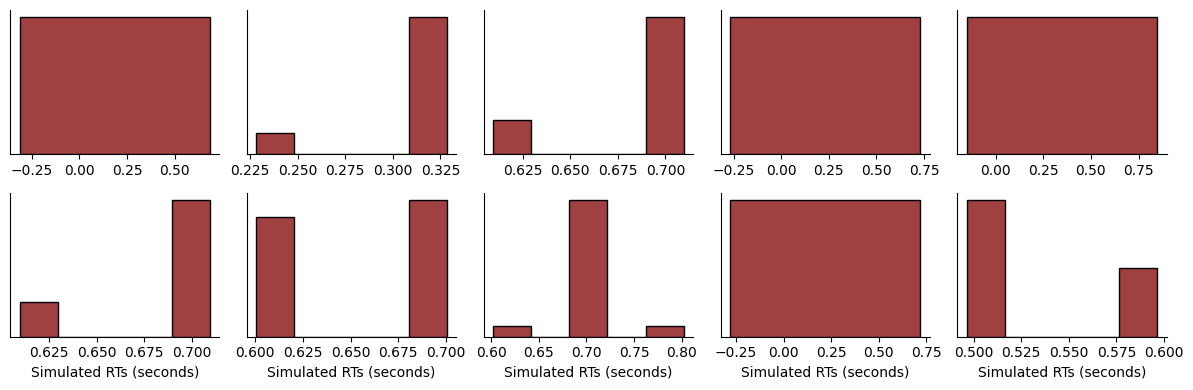

In [18]:
example_sim = model(batch_size=10)
f, axarr = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in enumerate(axarr.flat):
    sns.histplot(example_sim["sim_data"][i, :, 0].flatten(), color="maroon", alpha=0.75, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("")
    ax.set_yticks([])
    if i > 4:
        ax.set_xlabel("Simulated RTs (seconds)")
f.tight_layout()

Response

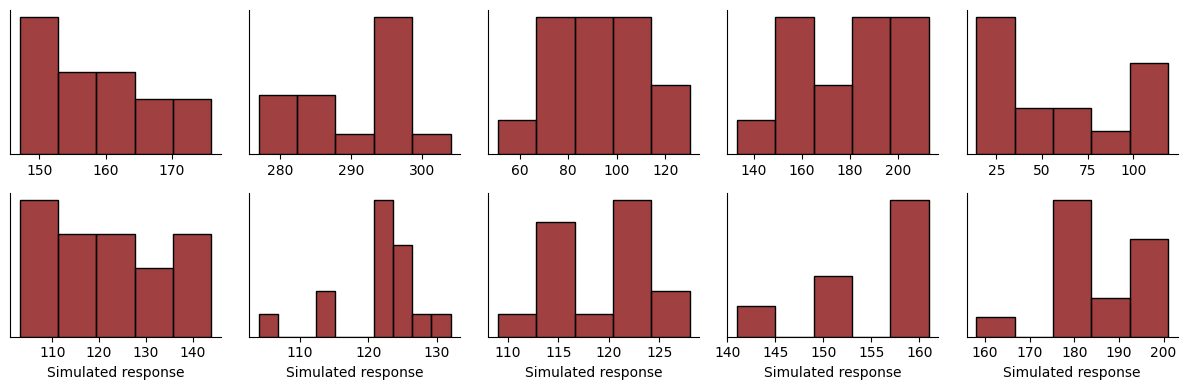

In [19]:
# example_sim = model(batch_size=10)
f, axarr = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in enumerate(axarr.flat):
    sns.histplot(example_sim["sim_data"][i, :, 1].flatten(), color="maroon", alpha=0.75, ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel("")
    ax.set_yticks([])
    if i > 4:
        ax.set_xlabel("Simulated response")
f.tight_layout()

##Summary Network

In [12]:
summary_net = bf.networks.DeepSet(summary_dim=5)

In [18]:
test_inp = model(batch_size=3)
summary_rep = summary_net(test_inp["sim_data"]).numpy()

print("Shape of simulated data sets: ", test_inp["sim_data"].shape)
print("Shape of summary vectors: ", summary_rep.shape)

Shape of simulated data sets:  (3, 10, 2)
Shape of summary vectors:  (3, 10)


##Inference Network

In [13]:
inference_net = bf.networks.InvertibleNetwork(
    num_params=5,
    num_coupling_layers=20,
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
)

##Amortizer

In [14]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

## Trained model

In [15]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model,checkpoint_path="./ratklif/model_check/20epo_128bath_15obj_5sum_20inf")

INFO:root:Loaded loss history from ./ratklif/model_check/20epo_128bath_15obj_5sum_20inf/history_9.pkl.
INFO:root:Networks loaded from ./ratklif/model_check/20epo_128bath_15obj_5sum_20inf/ckpt-9
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [ ]:
out = model(3)

print("Keys of simulated dict: ", list(out.keys()))

In [22]:
conf_out = trainer.configurator(out)

In [ ]:
print(conf_out['parameters'])
print("#####################")
out['prior_draws']

[[  1.0564296 156.65268    30.435028    2.3463604]
 [  0.9603366 100.34687    32.65539     1.0895786]
 [  1.2294546  70.70762    30.069994    1.41572  ]]
#####################


array([[  1.05642963, 156.65268398,  30.43502835,   2.34636055],
       [  0.96033662, 100.34687179,  32.65539239,   1.08957861],
       [  1.22945468,  70.70761916,  30.06999332,   1.41571996]])

In [ ]:
print(np.allclose(out["sim_data"], conf_out["summary_conditions"]))
print(np.allclose(out["prior_draws"], conf_out["parameters"]))

##Validation

In [16]:
# Generate some validation data
test_sims = trainer.configurator(model(500))


In [38]:
test_sims['summary_conditions'].shape

(500, 10, 2)

 Latent space inspection

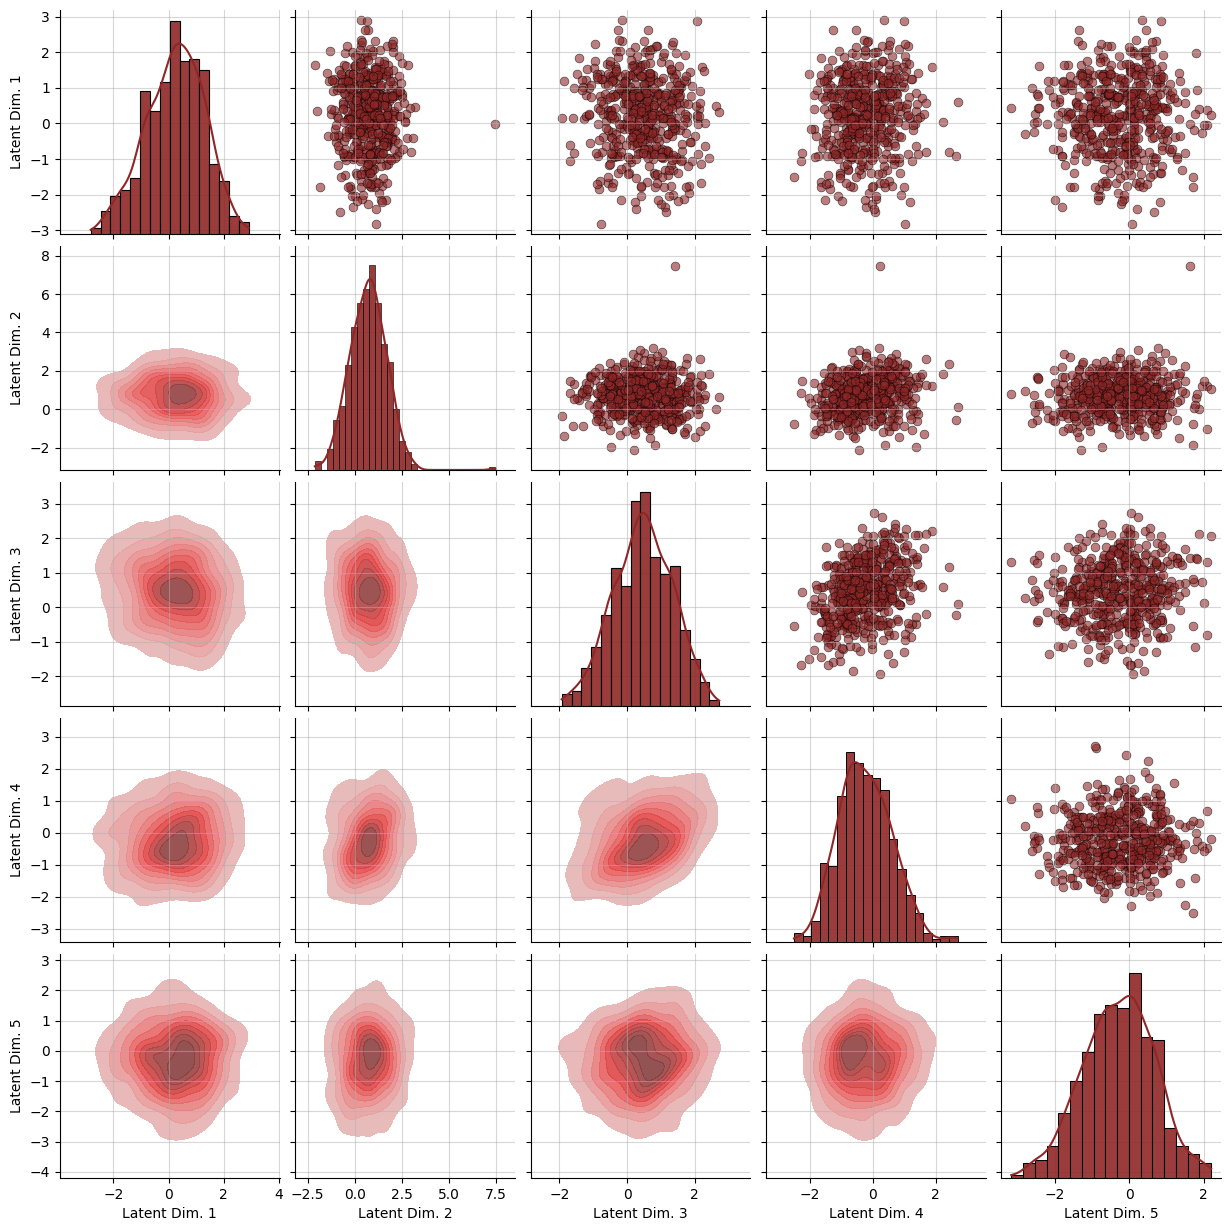

In [17]:
z_samples, _ = amortizer(test_sims)
f = bf.diagnostics.plot_latent_space_2d(z_samples)

Simulation-Based Calibration

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 1.                    Confidence intervals might be unreliable!


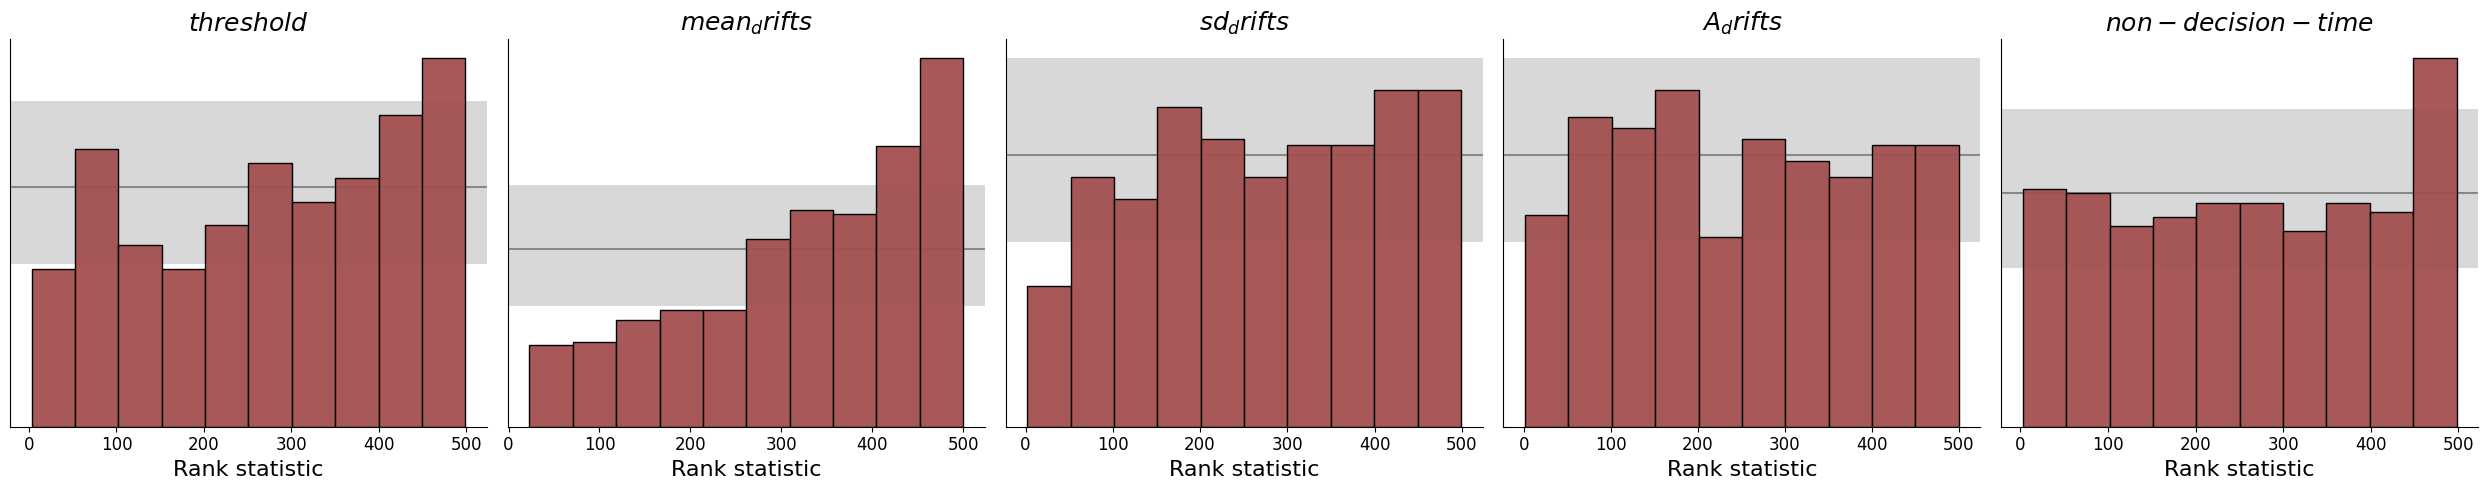

In [18]:
# Obtain 100 posterior samples for each simulated data set in test_sims
posterior_samples = amortizer.sample(test_sims, n_samples=500)
f = bf.diagnostics.plot_sbc_histograms(posterior_samples, test_sims["parameters"], num_bins=10,param_names=PARAM_NAMES)

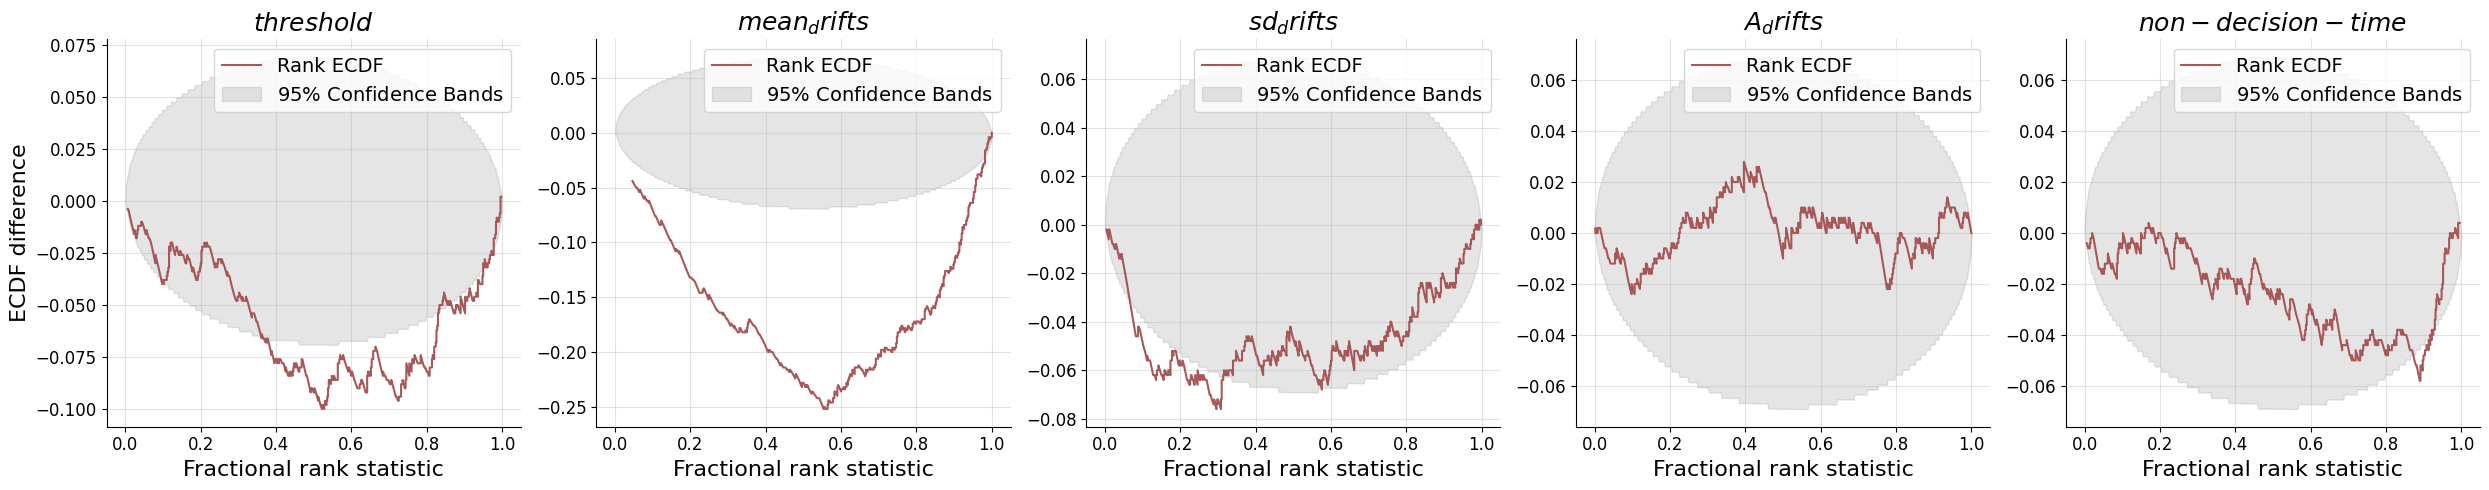

In [19]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_samples, test_sims["parameters"], difference=True,param_names=PARAM_NAMES)

Model Sensitivity

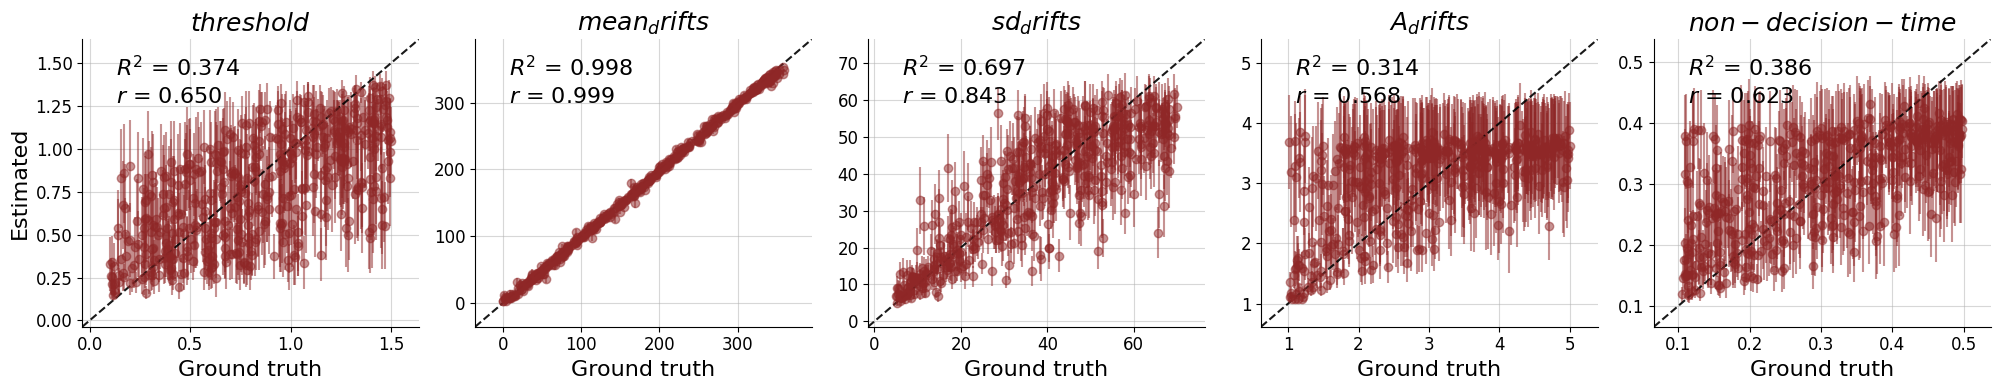

In [20]:
f = bf.diagnostics.plot_recovery(posterior_samples, test_sims["parameters"],param_names=PARAM_NAMES)

Z Score

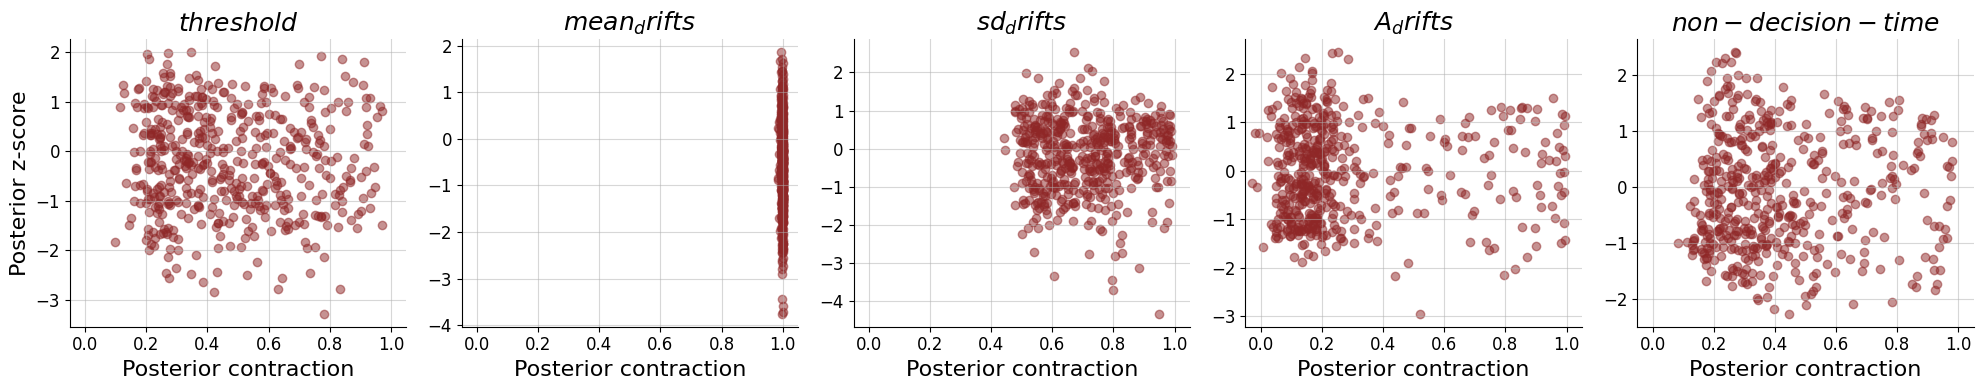

In [21]:
f = bf.diagnostics.plot_z_score_contraction(posterior_samples, test_sims["parameters"],param_names=PARAM_NAMES)

##Posterior Retrodictive Checks in Silico


1-Simulate data with our generative model.

2-Fit the model to these data.

3-esimulate new data with samples from the obtained posterior.

4-Compare (summary of) the simulated data and the resimulated data (model prediction).

In [29]:
# Define re-simulation settings
num_sim = 8
num_samples = 1000
num_resim = 50

Step 1

In [30]:
# Simulate and configure data
sim_data = model(batch_size=num_sim)
# conf_data = trainer.configurator(sim_data)
conf_data = sim_data
num_obs = sim_data["sim_data"].shape[1]

In [31]:
# Generate some validation data
test_sims = trainer.configurator(model(num_sim))

Step 2

In [32]:
# Fit model -> draw 1000 posterior samples per data set
post_samples = amortizer.sample(test_sims, n_samples=num_samples)
# Unstandardize posteriors draws into original scale
# post_samples_not_z = post_samples * prior_stds + prior_means

In [33]:
post_samples.shape

(8, 1000, 5)

In [34]:
def simulator2(params, n_object = 15, dt=1e-1):
    a,mean,sd,A,kernel_length,ndt = params[0],params[1],params[2],params[3],4,0.1
    # accumulation process
    out = np.zeros((n_object,2))
    x = np.arange(360,dtype=float)
    prob_x = normpdf(x,mean,sd,A)*dt
    for i in np.arange(n_object):
       num_iter = 0
       res = 0
       z = np.zeros(360,dtype=float)
       while res == 0 :
          # iterate over accumulators
          y = generate_gaussian_process(kernel_length, 360)
          y = y/10
          z = z + prob_x +(y*np.sqrt(dt))
          respons = np.where(z >= a)
          if np.size(respons) != 0:
              out[i,0] = num_iter * dt + ndt
              out[i,1] = float(np.random.choice(respons[0]))
              res = 1
              break
          num_iter += 1

    return out

Step 3

In [35]:
# Generate random index for posterior parameter set selection
index_set = np.random.choice(np.arange(num_samples), size=num_resim)

# Get context of simulated data sets
# context = sim_data["sim_batchable_context"]

# Re-simulate
pred_data = np.zeros((num_sim, num_resim, num_obs, 2))
for sim in range(num_sim):
    for i, idx in enumerate(index_set):
        for j in  range(num_obs):
            pred_data[sim, i, j, :] = simulator2(post_samples[sim, idx, :], n_object=1)

Step 4

/tmp/ipykernel_540428/2937619326.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_540428/2937619326.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_540428/2937619326.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_540428/2937619326.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


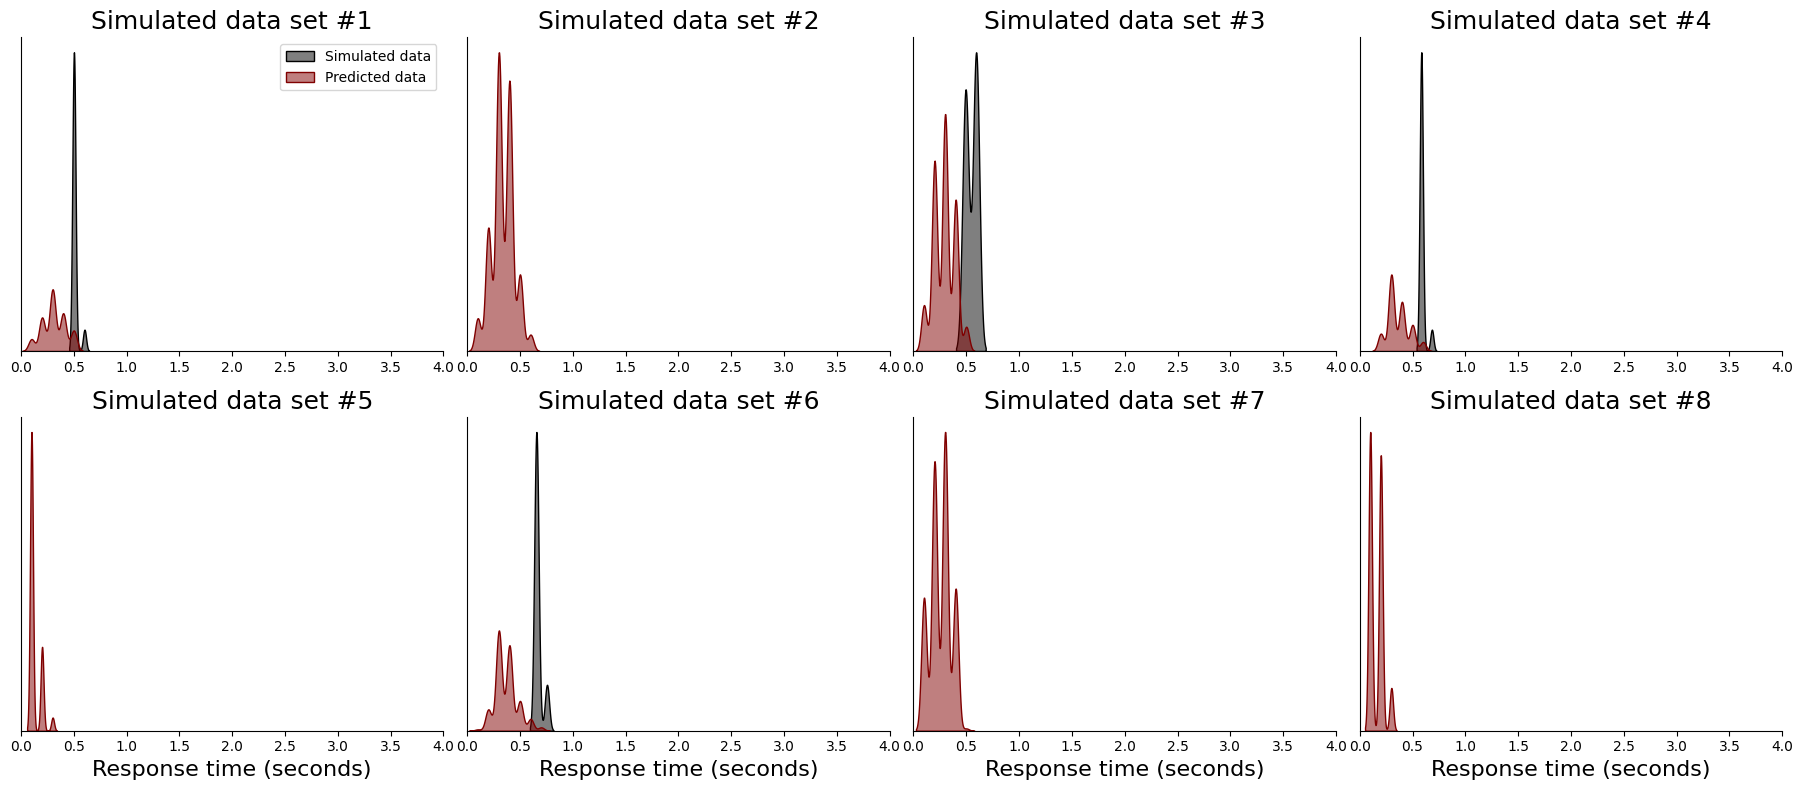

In [36]:
f, axarr = plt.subplots(2, 4, figsize=(18, 8))
for i, ax in enumerate(axarr.flat):
    sns.kdeplot(
        test_sims["summary_conditions"][i, :, 0], ax=ax, fill=True, color="black", alpha=0.5, label="Simulated data"
    )
    sns.kdeplot(pred_data[i, :, :, 0].flatten(), ax=ax, fill=True, color="maroon", alpha=0.5, label="Predicted data")
    ax.set_xlim((0, 4))
    ax.set_ylabel("")
    ax.set_yticks([])
    ax.set_title(f"Simulated data set #{i+1}", fontsize=18)
    # Set legend to first plot
    if i == 0:
        ax.legend()

    # Set x label to bottom row
    if i > (num_sim // 2) - 1:
        ax.set_xlabel("Response time (seconds)", fontsize=16)
    sns.despine()
f.tight_layout()